## Projekt z przedmiotu Sztuczna Inteligencja na temat:
### Zastosowanie sieci spolotowej w wybranym problemie klasyfikacji wizyjnej

In [1]:
# Importing all the libraries necessary for the project
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from random import randint
import time
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from scipy import ndimage
import torchvision
from tqdm.notebook import tqdm
import tensorflow as tf
from torchvision import transforms
from tqdm import tqdm
from flax.training import train_state
from typing import Any
import functools
import optax
# to suppress warnings caused by cuda version
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2024-05-31 12:18:08.648417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 12:18:11.207714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 1. Konfiguracja urządzenia:
<p>Ten fragment kodu ustawia urządzenie na GPU, jeśli jest dostępne, w przeciwnym razie używa CPU.</p>

In [2]:
# Ustawienie urządzenia na GPU, jeśli jest dostępne, w przeciwnym razie użycie CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


### 2. Wczytanie danych:
Wczytuje plik CSV zawierający etykiety obrazów do DataFrame.

In [3]:
# Definicja ścieżek do katalogu z danymi oraz pliku CSV zawierającego etykiety
DATA_DIR = '/home/mikolajmichalczyk/Documents/SI/projekt'
TRAIN_DIR = DATA_DIR + '/train'                           
TRAIN_CSV = DATA_DIR + '/labels.csv' 
# Wczytanie pliku CSV do DataFrame
data_df = pd.read_csv(TRAIN_CSV)

### 3. Mapowanie etykiet na indeksy:
<p> Uzyskuje unikalne nazwy ras i tworzy słownik mapujący etykiety na indeksy.</p>

In [4]:
# Uzyskanie unikalnych nazw ras i stworzenie słownika mapującego etykiety na indeksy
labels_names=data_df["breed"].unique()
labels_sorted=labels_names.sort()
labels = dict(zip(range(len(labels_names)),labels_names))

### 4. Dodanie etykiet do obrazów i etykiet do DataFrame:
<p>Tworzy listy zawierające ścieżki do obrazów i odpowiadające im etykiety, a następnie dodaje je do DataFrame.</p>
<ul><li>Tworzy listy zawierające ścieżki do obrazów i odpowiadające im etykiety, a następnie dodaje je do DataFrame.</li><li> Przetasowuje DataFrame w celu zapewnienia losowego rozmieszczenia próbek.</li><li> Próbkuje tylko 75% danych do dalszej analizy, aby zmniejszyć czas trenowania modelu.</li></ul>

In [5]:
# Inicjalizacja list do przechowywania etykiet i ścieżek do obrazów
lbl = []
path_img = []

# Wypełnienie list indeksami etykiet i ścieżkami do obrazów
for i in range(len(data_df["breed"])):
    temp1 = list(labels.values()).index(data_df.breed[i])
    lbl.append(temp1)
    temp2 = TRAIN_DIR + "/" + str(data_df.id[i]) + ".jpg"
    path_img.append(temp2)

# Dodanie ścieżek do obrazów i etykiet do DataFrame
data_df['path_img'] = path_img
data_df['lbl'] = lbl

# Przetasowanie DataFrame
data_df = data_df.sample(frac=1).reset_index(drop=True)

# Pobrane 75% DataFrame do trenowania
sampled_data_df = data_df.sample(frac=0.75, random_state=42).reset_index(drop=True)

# Wyświetlenie pierwszych kilku wierszy DataFrame
data_df.head()

,id,breed,path_img,lbl
0,d63348c8d835cd499da54d8de6a11803,tibetan_mastiff,/home/mikolajmichalczyk/Documents/SI/projekt/t...,108
1,a93e82d3fe942c7e871a8fe7202d4be6,scotch_terrier,/home/mikolajmichalczyk/Documents/SI/projekt/t...,96
2,e9da345a17d3e21041214e6cef9556a4,great_pyrenees,/home/mikolajmichalczyk/Documents/SI/projekt/t...,52
3,97f66937029b254fcf94be88cdffaf56,irish_terrier,/home/mikolajmichalczyk/Documents/SI/projekt/t...,57
4,c34f899f92484db897374e9567eda5b3,black-and-tan_coonhound,/home/mikolajmichalczyk/Documents/SI/projekt/t...,12


### 5. Definicja klasy zbioru danych:
<p>Klasa DogDataset do wczytywania obrazów psów i etykiet z DataFrame.</p>

In [6]:
class DogDataset(Dataset):
    """
    Niestandardowy zbiór danych do wczytywania obrazów psów i etykiet.
    """
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (DataFrame): DataFrame zawierający ścieżki do obrazów i etykiety.
            root_dir (str): Katalog z wszystkimi obrazami.
            transform (callable, optional): Opcjonalna transformacja do zastosowania na próbce.
        """
        self.df = df
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['id'], row['lbl']
        img_fname = self.root_dir + "/" + str(img_id) + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label

### 6. Transformacja obrazów:
Definiuje transformacje dla danych treningowych i walidacyjnych, w tym normalizację i inne augmentacje.

In [7]:
# Definicja wysokości i szerokości obrazów
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Definicja transformacji normalizującej
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Definicja transformacji danych treningowych
training_transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-30, 30), translate=(0.0, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    normalize,
])

# Definicja transformacji danych walidacyjnych/testowych
testing_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    normalize,
])

### 7. Przygotowanie danych do DataFrame:
<ul><li>Tworzy listy zawierające ścieżki do obrazów i odpowiadające im etykiety, a następnie dodaje je do DataFrame.</li><li> Przetasowuje DataFrame w celu zapewnienia losowego rozmieszczenia próbek.</li><li> Próbkuje tylko 75% danych do dalszej analizy, aby zmniejszyć czas trenowania modelu.</li></ul>

In [8]:
# Ustawienie ziarna generatora liczb losowych dla powtarzalności
np.random.seed(42)
# Stworzenie maski dla podziału 80-20 na zbiór treningowy i walidacyjny
msk = np.random.rand(len(data_df)) < 0.8

# Podział DataFrame na zbiór treningowy i walidacyjny
train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

# Stworzenie zbiorów danych treningowych i walidacyjnych
train_ds = DogDataset(train_df, TRAIN_DIR, transform=training_transform)
val_ds = DogDataset(val_df, TRAIN_DIR, transform=testing_transform)

In [9]:
# Wydrukowanie liczby dostępnych GPU i ich pamięci
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_properties(i).total_memory / (1024 ** 3):.2f} GB")

### 8. Stworzenie obiektów Dataloader:
<p>Tworzy DataLoadery do ładowania danych w partiach dla zbiorów treningowych i walidacyjnych.</p>

In [10]:
BATCH_SIZE = 128
# Stworzenie DataLoaderów dla zbiorów danych treningowych i walidacyjnych
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0,  pin_memory=True)

### 9. Sprawdzenie partii danych (batch):
<p>Pobiera i drukuje kształty partii danych treningowych i etykiet.</p>

In [11]:
# Pobranie partii danych treningowych i wydrukowanie kształtów obrazów i etykiet
(image_batch, label_batch) = next(iter(train_dataloader))
print(image_batch.shape)
print(label_batch.shape)

torch.Size([128, 3, 128, 128])
torch.Size([128])


### 10. Definicja modelu sieci neuronowej
<ul>
<li>__init__: Inicjalizuje warstwy sieci neuronowej, w tym warstwy konwolucyjne, batch normalization, ReLU, max pooling oraz warstwy klasyfikacyjne (fully connected).</li>
<li>forward: Definiuje przepływ danych przez sieć - najpierw przez warstwy konwolucyjne (features), a następnie przez warstwy klasyfikacyjne (classifier).</li></ul>

In [12]:
class VGG19(nn.Module):
    def __init__(self, num_classes):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

### 11. Inicjalizacja modelu i ustawienia treningowe:
<ul>
<li>Inicjalizacja modelu: Tworzy instancję modelu VGG19 z 120 klasami (num_classes).</li>
<li>Konfiguracja urządzenia: Ustawia model na GPU, jeśli jest dostępne.</li>
<li>Funkcja straty i optymalizator: Definiuje funkcję straty jako CrossEntropyLoss i optymalizator jako Adam.</li>
<li>AMP Scaler: Inicjalizuje skaler do automatycznego mieszania precyzji.</li></ul>

In [13]:
import torch.optim as optim
NUM_CLASSES = 120
model = VGG19(NUM_CLASSES)

# Ustawienie modelu na GPU, jeśli jest dostępnetorch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)                
# Definicja funkcji straty i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Inicjalizacja skaleru AMP (Automatic Mixed Precision)
scaler = torch.cuda.amp.GradScaler() 

### 12. Funkcja zapisu stanu modelu
<p>save_checkpoint: Funkcja zapisująca stan modelu, optymalizatora, skalera AMP oraz dodatkowe informacje, takie jak numer epoki i wartość straty, do pliku o nazwie filename.</p>

In [14]:
def save_checkpoint(model, optimizer, epoch, loss, filename, scaler):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)

### 13. definicja funkcji train_model:
<ul><li>Funkcja autocast pozwala na automatyczne skalowanie precyzji zmiennoprzecinkowej, co może przyspieszyć trening na GPU.</li>
<li>Funkcja train_model trenuje model przez określoną liczbę epok (num_epochs).</li>
<li>Przenosi model na odpowiednie urządzenie (device).</li>
<li>Dla każdej epoki ustawia model w tryb treningu i inicjalizuje zmienne do śledzenia straty i dokładności.</li>
<li>Używa paska postępu (tqdm) do śledzenia postępu treningu w bieżącej epoce.</li>
<li>Przetwarza mini-batche danych, przenosi je na odpowiednie urządzenie, zeruje gradienty, oblicza wyjścia modelu, stratę oraz aktualizuje wagi modelu przy użyciu skalera AMP.</li>
<li>Na koniec każdej epoki oblicza średnią stratę i dokładność, wyświetla je oraz zapisuje stan modelu i optymalizatora do pliku checkpoint.</li></ul>

In [15]:
from  torch.cuda.amp import autocast

model_path = '/home/mikolajmichalczyk/Documents/SI/projekt/model_checkpoint.pth'

def train_model(model, criterion, optimizer, num_epochs=10):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Epoch {start_epoch + epoch + 1}/{start_epoch + num_epochs}', ncols=100)
        
        for i, (images, labels) in progress_bar:
            images = images.to(device)  # Przeniesienie obrazów na odpowiednie urządzenie
            labels = labels.to(device)  # Przeniesienie etykiet na odpowiednie urządzenie
            optimizer.zero_grad(set_to_none=True)  # Wyzerowanie gradientów optymalizatora
            with autocast():  # Użycie automatycznego skalowania mieszanej precyzji
                outputs = model(images)  # Obliczenie wyjść modelu
                loss = criterion(outputs, labels)  # Obliczenie straty

            # Obliczenie gradientów i aktualizacja wag modelu przy użyciu skalowania AMP
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()  # Aktualizacja skumulowanej straty
            _, predicted = torch.max(outputs, 1)  # Pobranie predykcji
            total += labels.size(0)  # Aktualizacja całkowitej liczby próbek
            correct += (predicted == labels).sum().item()  # Aktualizacja liczby poprawnych predykcji
            # Aktualizacja paska postępu z bieżącą stratą i dokładnością
            progress_bar.set_postfix(loss=running_loss / (i + 1), accuracy=correct / total)

        epoch_loss = running_loss / len(train_dataloader)
        epoch_acc = correct / total
        print(f'Epoch {epoch + start_epoch}/{num_epochs+start_epoch}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        # zapisanie modelu
        save_checkpoint(model, optimizer, epoch = epoch, loss = epoch_loss, filename=model_path, scaler=scaler)


### 14. Funkcja load_checkpoint:
<ul><li>Określa ścieżkę do pliku, w którym będzie zapisywany stan modelu i optymalizatora.</li>
<li>Funkcja load_checkpoint ładuje stan modelu, optymalizatora, skalera AMP, numer epoki oraz wartość straty z pliku checkpoint.</li>
<li>Przenosi model na odpowiednie urządzenie po załadowaniu stanu.</li></ul>

In [16]:
def load_checkpoint(model, optimizer, filename, scaler):    
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss, scaler


### 15. Sprawdzenie, czy plik checkpoint nie jest pusty:
<ul>
<li>Używa funkcji os.path.getsize, aby sprawdzić, czy plik checkpoint nie jest pusty.</li>
<li>Jeśli plik nie jest pusty, ładuje stan modelu, optymalizatora i skalera AMP.</li>
<li>Jeśli plik jest pusty, ustawia start_epoch na 0 i loss na None.</li></ul>

In [17]:
if os.path.getsize(model_path) > 0:
    model, optimizer, start_epoch, loss, scaler = load_checkpoint(model, optimizer, model_path, scaler)
else:
    start_epoch = 0
    loss = None

### 16. Trenowanie i pomiar czasu:
<ul>
    <li>Rozpoczyna pomiar czasu, aby śledzić całkowity czas trwania treningu.</li>
    <li>Wywołuje funkcję train_model w celu rozpoczęcia treningu modelu na określoną liczbę epok.</li>
    <li>Wyświetla całkowity czas trwania treningu po jego zakończeniu.</li>
</ul>

In [18]:
start = time.time()
train_model(model, criterion, optimizer, num_epochs=2)
print("Total time: ", time.time() - start, "seconds")

Epoch 10/11: 100%|███████████████████████| 64/64 [03:03<00:00,  2.87s/it, accuracy=0.217, loss=3.19]


Epoch 9/11, Loss: 3.1864, Accuracy: 0.2174


Epoch 11/11: 100%|███████████████████████| 64/64 [03:07<00:00,  2.94s/it, accuracy=0.225, loss=3.13]

Epoch 10/11, Loss: 3.1346, Accuracy: 0.2251
Total time:  371.682147026062 seconds


### 17. Definicja funkcji ewaluacji modelu:
<ul>
    <li>Funkcja test_model testuje model na zbiorze walidacyjnym (test_dataloader).</li>
    <li>Ustawia model w tryb ewaluacji (model.eval()), co wyłącza obliczenia gradientów i inne mechanizmy specyficzne dla trybu treningu, takie jak dropout.</li>
    <li>Przenosi model na odpowiednie urządzenie (model.to(device)).</li>
    <li>Inicjalizuje zmienne do śledzenia liczby poprawnych predykcji (correct) i całkowitej liczby próbek (total).</li>
    <li>images, labels = next(iter(test_dataloader)) pobiera jeden batch danych z dataloadera walidacyjnego.</li>
    <li>Przenosi obrazy i etykiety na odpowiednie urządzenie (images.to(device), labels.to(device)).</li>
    <li>with torch.no_grad(): wyłącza obliczenia gradientów, co przyspiesza proces ewaluacji i zmniejsza zużycie pamięci.</li>
    <li>Dla każdej partii danych w dataloaderze walidacyjnym przenosi obrazy i etykiety na odpowiednie urządzenie.</li>
    <li>Przekazuje dane przez model (outputs = model(images)), oblicza predykcje (_, predicted = torch.max(outputs, 1)), aktualizuje całkowitą liczbę próbek (total) i liczbę poprawnych predykcji (correct).</li>
    <li>Oblicza dokładność jako stosunek liczby poprawnych predykcji do całkowitej liczby próbek (accuracy = correct / total).</li>
</ul>

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def test_model(model, criterion, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    correct = 0
    total = 0
    # Pobranie jednego batcha danych z dataloadera walidacyjnego
    images, labels = next(iter(test_dataloader))
    images = images.to(device)  # Przeniesienie obrazów na odpowiednie urządzenie
    labels = labels.to(device)  # Przeniesienie etykiet na odpowiednie urządzenie

    with torch.no_grad():  # Wyłączenie obliczeń gradientów w celu przyspieszenia procesu ewaluacji
        for images, labels in test_dataloader:
            images = images.to(device)  # Przeniesienie obrazów na odpowiednie urządzenie
            labels = labels.to(device)  # Przeniesienie etykiet na odpowiednie urządzenie

            # Przekazanie danych przez model (forward pass)
            outputs = model(images)

            # Obliczenie metryk
            _, predicted = torch.max(outputs, 1)  # Pobranie predykcji
            total += labels.size(0)  # Aktualizacja całkowitej liczby próbek
            correct += (predicted == labels).sum().item()  # Aktualizacja liczby poprawnych predykcji

    # Obliczenie dokładności na zbiorze walidacyjnym
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')  # Wyświetlenie dokładności

### 18. Wywołanie funkcji test_model:
<ul><li>test_model(model, criterion, val_dataloader, device) wywołuje funkcję test_model w celu przetestowania modelu na zbiorze walidacyjnym (val_dataloader).</li></ul>

In [20]:
test_model(model, criterion, val_dataloader, device)

Test Accuracy: 0.2531


### 19. Wyświetl obrazy i predykcje rasy:
<ul>
    <li>Funkcja przyjmuje jako argumenty model, dataloader testowy, urządzenie oraz listę nazw klas.</li>
    <li>model.eval() wyłącza tryb treningowy modelu.</li>
    <li>images, labels = next(iter(test_dataloader)) pobiera jeden batch danych.</li>
    <li>przenosi obrazy i etykiety na odpowiednie urządzenie.</li>
    <li>wybiera losowe obrazy</li>
    <li>tworzy figure z 2 rzędami i 4 kolumnam</li>
    <li>przekazuje obrazy do modelu i wyświetla wyniki predykcji</li>
    <li>wyświetla obrazy z informacją o prawdziwej i przewidzianej rasie psa</li>
</ul>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


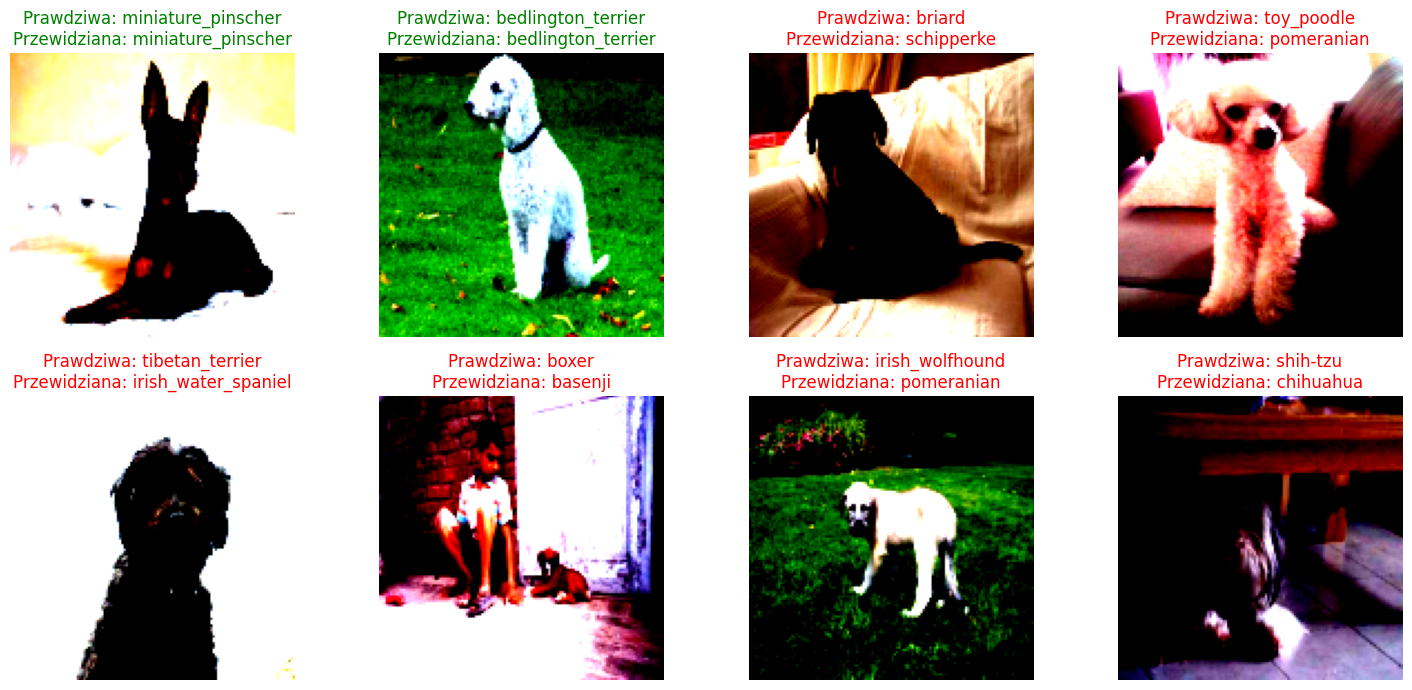

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_random_image_prediction(model, test_dataloader, device, class_names):
    """
    Funkcja wybiera losowe obrazy z zestawu testowego, przewiduje ich klasy za pomocą modelu
    i wyświetla te obrazy wraz z informacjami o predykcji.

    Args:
        model (torch.nn.Module): Wytrenowany model sieci neuronowej.
        test_dataloader (torch.utils.data.DataLoader): Dataloader zestawu testowego.
        device (torch.device): Urządzenie (CPU lub GPU) do przeprowadzenia predykcji.
        class_names (list): Lista nazw klas.
    """
    # Ustawienie modelu w tryb ewaluacji
    model.eval()
    model.to(device)  # Przeniesienie modelu na GPU (jeśli dostępne)

    # Pobranie obrazów i etykiet z dataloadera
    images, labels = next(iter(test_dataloader))
    images = images.to(device)
    labels = labels.to(device)

    # Wybranie losowych indeksów obrazów
    indices = np.random.choice(len(images), 8, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]

    # Tworzenie figure do wyświetlania obrazów
    fig, axes = plt.subplots(2, 4, figsize=(15, 7))

    with torch.no_grad():
        for i, ax in enumerate(axes.flat):
            # Przekazanie pojedynczego obrazu przez model
            img = selected_images[i].unsqueeze(0)
            output = model(img)
            _, predicted = torch.max(output, 1)
            prediction = predicted.item()

            # Konwersja obrazu do formatu wyświetlanego przez matplotlib
            image = selected_images[i].cpu().numpy().transpose((1, 2, 0))
            label = selected_labels[i].item()

            # Wyświetlenie obrazu wraz z informacją o prawdziwej i przewidzianej klasie
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f'Prawdziwa: {class_names[label]}\nPrzewidziana: {class_names[prediction]}')

            # Sprawdzenie poprawności predykcji
            if prediction == label:
                ax.set_title(f'Prawdziwa: {class_names[label]}\nPrzewidziana: {class_names[prediction]}', color='green')
            else:
                ax.set_title(f'Prawdziwa: {class_names[label]}\nPrzewidziana: {class_names[prediction]}', color='red')

    # Wyświetlenie wszystkich obrazów na figure
    plt.tight_layout()
    plt.show()

# Przykład użycia:
show_random_image_prediction(model, val_dataloader, device, labels_names)